# Lib importing

#!pip install kaggle
!pip uninstall -y kaggle
#!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 83kB/s 


In [1]:
#import libs
import cv2
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, UpSampling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from keras import backend as T
import os
import pandas as pd
import numpy as np
import pickle
import pydicom
from pydicom.filereader import read_dicomdir
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import patches
style.use('ggplot')
import h5py
%matplotlib inline
import math

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#TO extract data folder from zip file
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/capstone/stage_2_train_images.zip', 'r') as z:
    z.extractall()

In [2]:
#Extracting dataframe
df = pd.read_csv('/content/drive/My Drive/capstone/stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
#Length of dataframe
len(df)

30227

In [4]:
#getting cases only of pneumonia
df_1=0
df_1=df[df['Target']==1]
length1=len(df_1)
df_1.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
#getting cases only of non pneumonia
df_0=df[df['Target']==0]
length0=len(df_0)
df_0.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [6]:
#Print length of both dataset
print(length1)
print(length0)

9555
20672


In [7]:
#creating a dataframe with the patient ids which have bounding boxes and there count
df_id_vc=pd.DataFrame(df_1['patientId'].value_counts())
df_id_vc.reset_index(inplace=True)
df_id_vc.rename(columns={"index":"patientId","patientId":"vc"},inplace=True)
df_id_vc=df_id_vc[df_id_vc.vc>=1]
print(df_id_vc.shape)
df_id_vc.head()

(6012, 2)


,patientId,vc
0,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,4
1,31764d54-ea3b-434f-bae2-8c579ed13799,4
2,8dc8e54b-5b05-4dac-80b9-fa48878621e2,4
3,0ab261f9-4eb5-42ab-a9a5-e918904d6356,4
4,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,4


In [8]:
#Getting only first 1000 cases of non pneumonia
df_0=df_0.iloc[0:1000,:]
len(df_0)

1000

In [0]:
#Ching postion of dataframe
df_1=df_1[['patientId','Target','x','y','width','height']]

In [10]:
total2=len(df_id_vc['patientId'].unique()) #total number of mask and images
print(total2)

6012


In [11]:
len(df_id_vc)

6012

In [12]:
#Appending non pneumonia cases to pneumonia
df_id_vc = df_id_vc.append(df_0)
df_id_vc.tail()

,patientId,vc,x,y,width,height,Target
1743,185d494c-3ec2-4317-bb8a-bcd0f9ce7615,NaN,NaN,NaN,NaN,NaN,0.0
1744,18630633-df6f-4b2c-b3df-23704d84f5be,NaN,NaN,NaN,NaN,NaN,0.0
1745,1863f91d-3b5e-413d-a0ac-f97a7c006334,NaN,NaN,NaN,NaN,NaN,0.0
1746,186b30df-a0e3-4b33-a49a-8b77f4240116,NaN,NaN,NaN,NaN,NaN,0.0
1747,1871337b-8e0b-4329-93a4-b0d9afc5c814,NaN,NaN,NaN,NaN,NaN,0.0


In [13]:
#To see total length of data i.e no. of pneumonia and non pneumonia cases
len(df_id_vc)

7012

In [0]:
#Appending non pneumonia cases to pneumonia
df_1=df_1.append(df_0)

In [0]:
#replacind nan with 0
df_1['x'] = df_1['x'].fillna(0)
df_1['y'] = df_1['y'].fillna(0)
df_1['width'] = df_1['width'].fillna(0)
df_1['height'] = df_1['height'].fillna(0)

In [16]:
#To see total length of data i.e no. of pneumonia and non pneumonia cases
k = len(df_id_vc)
k

7012

In [17]:
len(df_1)

10555

In [18]:
#Sezing images and storing it into an array 
#Creating an array of bounding boxes
IMAGE_HEIGHT=256
IMAGE_WIDTH=256
coords = np.zeros((k, 4, 4), dtype=float)
X_train = np.zeros((k, IMAGE_HEIGHT, IMAGE_WIDTH))
count=0
for i in range(k):
    img = pydicom.read_file('/content/stage_2_train_images/'+df_id_vc.iloc[i,0]+'.dcm')
    img = img.pixel_array
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    X_train[i] = preprocess_input(np.array(img, dtype=np.float32))
    
    bb=np.array(df_1[df_1['patientId']==df_id_vc.iloc[i,0]])
    count=count+1
    for j,q in enumerate(bb):
      coords[i][j,0]= float(q[2] * IMAGE_HEIGHT / 1024)
      coords[i][j,1] = float(q[3] * IMAGE_HEIGHT / 1024)
      coords[i][j,2] = float(q[4] * IMAGE_HEIGHT / 1024)
      coords[i][j,3] = float(q[5] * IMAGE_HEIGHT / 1024) 
    
    
print(count)

7012


In [19]:
df_id_vc.head()

,patientId,vc,x,y,width,height,Target
0,349f10b4-dc3e-4f3f-b2e4-a5b81448ce87,4.0,NaN,NaN,NaN,NaN,NaN
1,31764d54-ea3b-434f-bae2-8c579ed13799,4.0,NaN,NaN,NaN,NaN,NaN
2,8dc8e54b-5b05-4dac-80b9-fa48878621e2,4.0,NaN,NaN,NaN,NaN,NaN
3,0ab261f9-4eb5-42ab-a9a5-e918904d6356,4.0,NaN,NaN,NaN,NaN,NaN
4,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,4.0,NaN,NaN,NaN,NaN,NaN


In [20]:
#print shape of data
print(X_train.shape)
print(coords.shape)

(7012, 256, 256)
(7012, 4, 4)


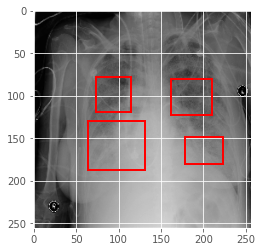

In [21]:
#printing 1 sample image along with coordinates
n=1
fig,ax = plt.subplots(1)
ax.imshow(X_train[n], cmap=plt.cm.gray)
rect = patches.Rectangle((coords[n][0,0], coords[n][0,1]), (coords[n][0,2]) , (coords[n][0,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((coords[n][1,0], coords[n][1,1]), (coords[n][1,2]) , (coords[n][1,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((coords[n][2,0], coords[n][2,1]), (coords[n][2,2]) , (coords[n][2,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((coords[n][3,0], coords[n][3,1]), (coords[n][3,2]) , (coords[n][3,3]) , linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()

In [22]:
print(coords[n])

[[ 64.5  130.25  66.5   57.25]
 [ 73.25  77.75  41.5   41.75]
 [178.25 148.25  45.25  32.5 ]
 [162.25  79.75  47.5   43.  ]]


In [23]:
for i in range(len(df)):
  if df.iloc[i,0]=='370e4257-86fb-40b7-a4df-b8a3a7b25226':
    print(df.iloc[i,1]*360/1024,df.iloc[i,2]*360/1024,df.iloc[i,3]*360/1024,df.iloc[i,4]*360/1024)

63.6328125 55.1953125 99.140625 211.9921875
214.453125 96.328125 82.96875 210.234375


In [24]:
#changing shape of data so that it can be supplied to the model
print(X_train.shape)
print(coords.shape)
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
coords = coords.reshape(coords.shape[0], 1, 4, 4)
print(X_train.shape)
print(coords.shape)

(7012, 256, 256)
(7012, 4, 4)
(7012, 256, 256, 1)
(7012, 1, 4, 4)


In [0]:
#Splitting data into train test and validation
X_train, X_test1, y_train, y_test1 = train_test_split(X_train, coords, test_size=0.10, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.27, random_state=42)

### mobile net

In [0]:
#Defing model parameter alpha
ALPHA = 1.0

In [27]:
#model building
#here first conv layer is added to give model imahge of shape 3 
IMAGE_HEIGHT = 256
IMAGE_HEIGHT = 256
input_tensor = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,1) )
x2 = Conv2D(3, (3,3), padding='same', name="coords1")(input_tensor) 

model2 = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights = "imagenet") 

for layer in model2.layers:
    layer.trainable = True
    
x1 = model2(x2)

x = Dropout((0.4))(x1)
x = Conv2D(8, (5,4), name="coords2")(x)
x = Dropout((0.4))(x)
x = Conv2D(4, (4,2), name="coords3")(x)


model2 = Model(inputs=input_tensor, outputs=x)

In [28]:
#print model summary
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
coords1 (Conv2D)             (None, 256, 256, 3)       30        
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1024)        0         
_________________________________________________________________
coords2 (Conv2D)             (None, 4, 5, 8)           163848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 5, 8)           0         
_________________________________________________________________
coords3 (Conv2D)             (None, 1, 4, 4)           260   

In [0]:
#Compiling model
model2.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy']) # Regression loss is MSE


In [30]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, min_lr=1e-6, verbose=1, mode="min") 

In [31]:
#fitting model to traing set
r = model2.fit(
  X_train,
  y_train,
  batch_size=100,
  epochs=50,
  validation_data=(X_val,y_val),
  callbacks=[reduce_lr, checkpoint],
  verbose=1
)

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 1225.0596 - accuracy: 0.3470
Epoch 00001: val_accuracy improved from inf to 0.68701, saving model to model-1225.06.h5
64/64 [==============================] - 80s 1s/step - loss: 1225.0596 - accuracy: 0.3470 - val_loss: 1192.0051 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 968.3372 - accuracy: 0.3760
Epoch 00002: val_accuracy improved from 0.68701 to 0.30225, saving model to model-968.34.h5
64/64 [==============================] - 78s 1s/step - loss: 968.3372 - accuracy: 0.3760 - val_loss: 940.7283 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 884.9684 - accuracy: 0.3942
Epoch 00003: val_accuracy did not improve from 0.30225
64/64 [==============================] - 78s 1s/step - loss: 884.9684 - accuracy: 0.3942 - val_loss: 1033.0239 - val_accuracy: 0.3828 - lr: 0.0010
Epoch 4/50
64/64 [================

In [0]:
#Save model last wts
model2.save_weights('/content/drive/My Drive/capstone/mobile_wts2/last_wts.h5')

In [0]:
#load model wts
model2.load_weights('/content/drive/My Drive/capstone/mobile_wts2/last_wts.h5')

In [0]:
#Copying model checkpoints weights
!cp /content/model-1207.13.h5 /content/drive/My\ Drive/capstone/mobile_wts2
!cp /content/model-1225.06.h5 /content/drive/My\ Drive/capstone/mobile_wts2
!cp /content/model-546.63.h5 /content/drive/My\ Drive/capstone/mobile_wts2
!cp /content/model-585.54.h5 /content/drive/My\ Drive/capstone/mobile_wts2
!cp /content/model-968.34.h5 /content/drive/My\ Drive/capstone/mobile_wts2



In [37]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [1225.0595703125, 968.3372192382812, 884.9684448242188, 827.576416015625, 740.01318359375, 648.8587036132812, 585.5424194335938, 546.6327514648438, 441.8337097167969, 388.3470764160156, 310.0490417480469, 257.9518737792969, 232.74136352539062, 221.00192260742188, 206.16180419921875, 201.2130889892578, 201.00254821777344, 197.87353515625, 192.64434814453125, 193.19448852539062, 192.77976989746094, 193.21713256835938, 192.8859405517578, 191.57766723632812, 190.3181610107422, 191.3967742919922, 189.24783325195312, 190.57516479492188, 189.2759246826172, 189.78964233398438, 188.9009552001953, 190.16445922851562, 190.16815185546875, 189.42041015625, 192.1879119873047, 188.68345642089844, 188.05877685546875, 190.05738830566406, 187.1068572998047, 191.297607421875, 187.29676818847656, 187.99253845214844, 188.15072631835938, 187.92103576660156, 191.3157958984375, 187.57020568847656, 187.84112548828125, 189.05670166015625, 189.39859008789062, 190.07803344726562], 'accuracy': [0.34702852

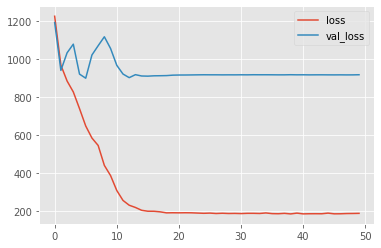

In [38]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

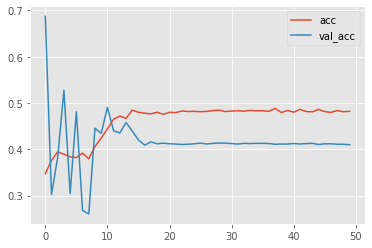

In [39]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [51]:
#See model performance
model2.evaluate(X_test, y_test, verbose=1)

6/6 [==============================] - 1s 89ms/step - loss: 1011.7457 - accuracy: 0.4105


[1011.7456665039062, 0.410526305437088]

In [52]:
#model predictions alonf with ground truth 
n=100
img=X_test[n].reshape(1,256,256,1)
k=model2.predict(img)
print(k)
print(y_test[n])

[[[[21.574986   23.427204   12.395524   16.272692  ]
   [ 0.5846139  -1.4090201  -0.53361106  0.1746433 ]
   [ 0.11720315  0.34306237  0.48157975  1.4034536 ]
   [-0.13733238 -0.44079676  0.2418665   0.53268105]]]]
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [53]:
#output from model
print(k[0][0][0])
print(k[0][0][1])

[21.574986 23.427204 12.395524 16.272692]
[ 0.5846139  -1.4090201  -0.53361106  0.1746433 ]


[[[[101.85848     84.26997     34.466892    34.36043   ]
   [  3.953277    -4.4015346    0.44807887   0.8561849 ]
   [ -3.75995     -4.001023     0.25132346   0.92225456]
   [  1.06674      1.2263565    0.12360118  -0.17644916]]]]
[[[149.25 118.25  80.75  34.75]
  [  0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  ]]]


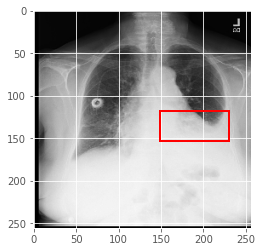

[[[149.25 118.25  80.75  34.75]
  [  0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  ]]]


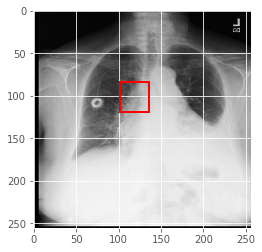

[[[[101.85848     84.26997     34.466892    34.36043   ]
   [  3.953277    -4.4015346    0.44807887   0.8561849 ]
   [ -3.75995     -4.001023     0.25132346   0.92225456]
   [  1.06674      1.2263565    0.12360118  -0.17644916]]]]


In [54]:
#see model predictions 
n=12
img=X_test[n].reshape(1,256,256,1)
k=model2.predict(img)
print(k)
print(y_test[n])

#plotting a image with bound box and print label
# Create figure and axes
fig,ax = plt.subplots(1)

ax.imshow(X_test[n].reshape(256,256), cmap=plt.cm.gray)

# Create a Rectangle patch
rect = patches.Rectangle((y_test[n,0,0,0], y_test[n,0,0,1]), (y_test[n,0,0,2]), (y_test[n,0,0,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((y_test[n,0,1,0], y_test[n,0,1,1]), (y_test[n,0,1,2]),  (y_test[n,0,1,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((y_test[n,0,2,0], y_test[n,0,2,1]), (y_test[n,0,2,2]),  (y_test[n,0,2,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((y_test[n,0,3,0], y_test[n,0,3,1]), (y_test[n,0,3,2]),  (y_test[n,0,3,3]) , linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()
print(y_test[n])


#plotting a image with bound box and print label
# Create figure and axes
fig,ax = plt.subplots(1)

ax.imshow(X_test[n].reshape(256,256), cmap=plt.cm.gray)

# Create a Rectangle patch
rect = patches.Rectangle((k[0][0][0][0], k[0][0][0][1]), (k[0][0][0][2]), (k[0][0][0][3]) , linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((k[0][0][1][0], k[0][0][1][1]), (k[0][0][1][2]), (k[0][0][1][3]) , linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((k[0][0][2][0], k[0][0][2][1]), (k[0][0][2][2]), (k[0][0][2][3]) , linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((k[0][0][3][0], k[0][0][3][1]), (k[0][0][3][2]), (k[0][0][3][3]) , linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()
print(k)

In [58]:
#plotting the bounding boxes and images for the patients selected above
style.use('ggplot')
num_of_img=20 #number of images u want to plot
fig, axs = plt.subplots(math.ceil(num_of_img/4),4,figsize=(100,100))

for n in np.arange(0,num_of_img):
  plt.subplot(math.ceil(num_of_img/4),4,n+1) #create subplot
  #fig=plt.imshow(X_test[i], cmap=plt.cm.bone)

  fig=plt.imshow(X_test[n].reshape(256,256), cmap=plt.cm.gray)

# Create a ground truth Rectangle patch with blue
  rect = patches.Rectangle((y_test[n,0,0,0], y_test[n,0,0,1]), (y_test[n,0,0,2]), (y_test[n,0,0,3]) , linewidth=2, edgecolor='b', facecolor='none')
  rect2 = patches.Rectangle((y_test[n,0,1,0], y_test[n,0,1,1]), (y_test[n,0,1,2]),  (y_test[n,0,1,3]) , linewidth=2, edgecolor='b', facecolor='none')
  rect3 = patches.Rectangle((y_test[n,0,2,0], y_test[n,0,2,1]), (y_test[n,0,2,2]),  (y_test[n,0,2,3]) , linewidth=2, edgecolor='b', facecolor='none')
  rect4 = patches.Rectangle((y_test[n,0,3,0], y_test[n,0,3,1]), (y_test[n,0,3,2]),  (y_test[n,0,3,3]) , linewidth=2, edgecolor='b', facecolor='none')

  fig.axes.add_patch(rect)
  fig.axes.add_patch(rect2)
  fig.axes.add_patch(rect3)
  fig.axes.add_patch(rect4)

  
  img=X_test[n].reshape(1,256,256,1)
  k=model2.predict(img)


  # Create a predicted Rectangle patch with red
  rect = patches.Rectangle((k[0][0][0][0], k[0][0][0][1]), (k[0][0][0][2]), (k[0][0][0][3]) , linewidth=2, edgecolor='r', facecolor='none')
  rect2 = patches.Rectangle((k[0][0][1][0], k[0][0][1][1]), (k[0][0][1][2]), (k[0][0][1][3]) , linewidth=2, edgecolor='r', facecolor='none')
  rect3 = patches.Rectangle((k[0][0][2][0], k[0][0][2][1]), (k[0][0][2][2]), (k[0][0][2][3]) , linewidth=2, edgecolor='r', facecolor='none')
  rect4 = patches.Rectangle((k[0][0][3][0], k[0][0][3][1]), (k[0][0][3][2]), (k[0][0][3][3]) , linewidth=2, edgecolor='r', facecolor='none')

  fig.axes.add_patch(rect)
  fig.axes.add_patch(rect2)
  fig.axes.add_patch(rect3)
  fig.axes.add_patch(rect4)


  #fig.axes.add_patch(bb)

  #fig.axes.add_patch(bb2)
plt.show()


Output hidden; open in https://colab.research.google.com to view.